# Analyzing the Spread of Misinformation in Social Networks
## Using Random Graph Models, SIR Simulation, and Classification Models

**Overview:**  
This notebook integrates data from four FakeNewsNet datasets to analyze the spread of misinformation. It covers:
1. Data loading and preprocessing (with fake/real labeling)
2. Classification models (TF-IDF + Logistic Regression and fine-tuned BERT)
3. Synthetic network modeling using data-driven nodes for both Barabási–Albert (BA) and Erdős–Rényi (ER) models
4. SIR simulations on these networks with network graph outputs
5. Sensitivity analysis on infection probability
6. Advanced network metrics and community detection (Louvain)

**Future Work:**  
Extend sensitivity analysis to other parameters, incorporate node weights from classification scores, and compare results with real social network data.

## 1. Import Libraries and Setup

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# For classification and NLP
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

# For community detection
import community as community_louvain  

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/peipei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Data Loading and Preprocessing

I load four FakeNewsNet datasets, clean the text data, and assign a label:
- Fake news = 1
- Real news = 0

The datasets are then combined into a single DataFrame.

In [3]:
# Load datasets from FakeNewsNet/Dataset
gossipcop_fake = pd.read_csv('FakeNewsNet/Dataset/gossipcop_fake.csv')
gossipcop_real = pd.read_csv('FakeNewsNet/Dataset/gossipcop_real.csv')
politifact_fake = pd.read_csv('FakeNewsNet/Dataset/politifact_fake.csv')
politifact_real = pd.read_csv('FakeNewsNet/Dataset/politifact_real.csv')

# Display columns for inspection
print("GossipCop Fake Columns:", gossipcop_fake.columns.tolist())
print("GossipCop Real Columns:", gossipcop_real.columns.tolist())
print("PolitiFact Fake Columns:", politifact_fake.columns.tolist())
print("PolitiFact Real Columns:", politifact_real.columns.tolist())

GossipCop Fake Columns: ['id', 'news_url', 'title', 'tweet_ids']
GossipCop Real Columns: ['id', 'news_url', 'title', 'tweet_ids']
PolitiFact Fake Columns: ['id', 'news_url', 'title', 'tweet_ids']
PolitiFact Real Columns: ['id', 'news_url', 'title', 'tweet_ids']


In [21]:
# Define text cleaning function
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if pd.isna(text):
        return ""
    text = re.sub(r'<.*?>', '', text)          # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)      # Remove non-alphabet characters
    text = text.lower()                          # Convert to lowercase
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

def apply_cleaning(df):
    # Check for 'title' or 'content' column
    if 'title' in df.columns:
        source_col = 'title'
    elif 'content' in df.columns:
        source_col = 'content'
    else:
        print("No text column found!")
        return df
    df['cleaned_text'] = df[source_col].apply(clean_text)
    return df

# Clean each dataset
gossipcop_fake = apply_cleaning(gossipcop_fake)
gossipcop_real = apply_cleaning(gossipcop_real)
politifact_fake = apply_cleaning(politifact_fake)
politifact_real = apply_cleaning(politifact_real)

# Assign labels
gossipcop_fake['label'] = 1
politifact_fake['label'] = 1
gossipcop_real['label'] = 0
politifact_real['label'] = 0

# Combine all datasets and drop missing texts
combined_df = pd.concat([gossipcop_fake, gossipcop_real, politifact_fake, politifact_real], ignore_index=True)
combined_df = combined_df.dropna(subset=['cleaned_text'])
print("Combined dataset shape:", combined_df.shape)

Combined dataset shape: (23196, 6)


## 3. Classification Models

I build two models to classify fake vs. real news:
1. **TF-IDF + Logistic Regression (Baseline)**
2. **Fine-Tuned BERT**

The performance of both models is printed for comparison.

In [22]:
# Prepare data for classification
X = combined_df['cleaned_text']
y = combined_df['label']

# TF-IDF Vectorization and Logistic Regression
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred_tfidf = clf.predict(X_test)

print("TF-IDF Baseline Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print(classification_report(y_test, y_pred_tfidf))

TF-IDF Baseline Results:
Accuracy: 0.8400862068965518
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      3492
           1       0.82      0.45      0.58      1148

    accuracy                           0.84      4640
   macro avg       0.83      0.71      0.74      4640
weighted avg       0.84      0.84      0.82      4640



In [6]:
# BERT Fine-Tuning
hf_dataset = Dataset.from_pandas(combined_df[['cleaned_text', 'label']])
split_dataset = hf_dataset.train_test_split(test_size=0.2, seed=42)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(example):
    return tokenizer(example["cleaned_text"], truncation=True, padding="max_length", max_length=128)

tokenized_datasets = split_dataset.map(tokenize_function, batched=True)
cols_to_remove = [col for col in ["cleaned_text", "__index_level_0__"] if col in tokenized_datasets["train"].column_names]
tokenized_datasets = tokenized_datasets.remove_columns(cols_to_remove)
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
)

trainer.train()
bert_results = trainer.evaluate()
print("BERT Evaluation Results:", bert_results)

Map:   0%|          | 0/18556 [00:00<?, ? examples/s]

Map:   0%|          | 0/4640 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/peipei/anaconda3/lib/python3.11/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/cn/wqzk89gx2hv061vhqvfb94yw0000gn/T/ipykernel_4886/1430869092.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.379300,0.367432
2,0.308500,0.397352
3,0.213400,0.437919


BERT Evaluation Results: {'eval_loss': 0.3674315810203552, 'eval_runtime': 60.7854, 'eval_samples_per_second': 76.334, 'eval_steps_per_second': 4.771, 'epoch': 3.0}


In [23]:
# Get predictions from the BERT model on the test dataset
bert_preds_output = trainer.predict(tokenized_datasets["test"])
bert_preds = np.argmax(bert_preds_output.predictions, axis=1)
y_test_bert = tokenized_datasets["test"]["labels"]

# Compute the overall accuracy and detailed classification metrics
accuracy = accuracy_score(y_test_bert, bert_preds)
report = classification_report(y_test_bert, bert_preds, output_dict=True)

# Extract performance metrics for class '0' (Real) and class '1' (Fake)
precision_real = report['0']['precision']
recall_real = report['0']['recall']
f1_real = report['0']['f1-score']

precision_fake = report['1']['precision']
recall_fake = report['1']['recall']
f1_fake = report['1']['f1-score']

# Create a DataFrame to neatly display the results
bert_performance = pd.DataFrame({
    'Model': ['BERT'],
    'Accuracy': [accuracy],
    'Precision (Real)': [precision_real],
    'Recall (Real)': [recall_real],
    'F1-Score (Real)': [f1_real],
    'Precision (Fake)': [precision_fake],
    'Recall (Fake)': [recall_fake],
    'F1-Score (Fake)': [f1_fake]
})

print("BERT Model Performance Metrics:")
print(bert_performance)

BERT Model Performance Metrics:
  Model  Accuracy  Precision (Real)  Recall (Real)  F1-Score (Real)  \
0  BERT  0.845905          0.889419       0.908023         0.898625   

   Precision (Fake)  Recall (Fake)  F1-Score (Fake)  
0           0.70195       0.657391          0.67894  


## 4. Network Modeling and SIR Simulation Using Data Attributes

I sample 1,000 nodes from the combined dataset to represent articles (nodes). Each node is assigned its fake/real label.  
I then generate synthetic networks using:
- **Barabási–Albert (BA) Model**
- **Erdős–Rényi (ER) Model**

For each network, I output the network graph and run an SIR simulation.

### 4.1 BA Network: Graph Generation, Visualization, and SIR Simulation

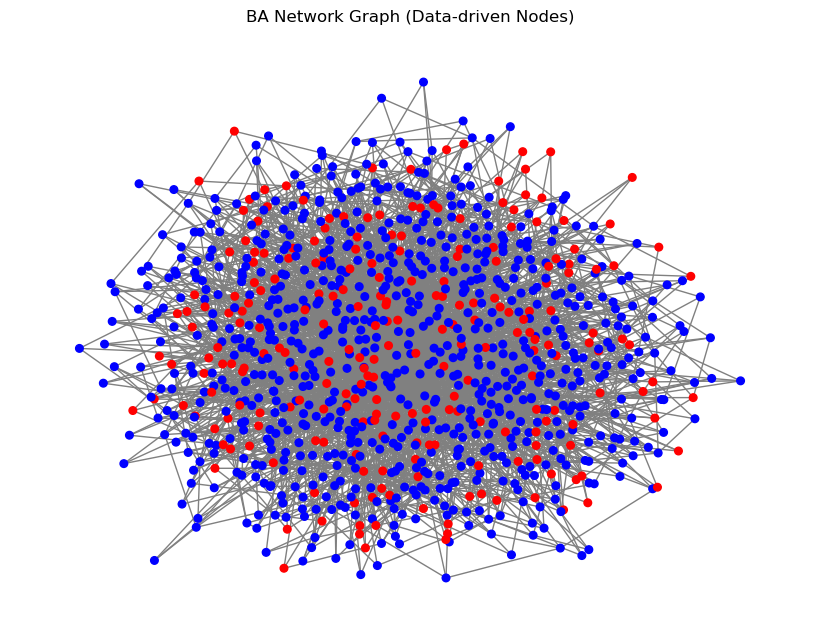

In [8]:
# Sample nodes from the combined dataset
sample_size = 1000
combined_sample = combined_df.sample(n=sample_size, random_state=42).reset_index(drop=True)

# Generate a BA network with sample_size nodes
ba_m = 3  # Each new node attaches to 3 existing nodes
G_ba = nx.barabasi_albert_graph(sample_size, ba_m, seed=42)

# Assign node attributes from the combined sample
for i in range(sample_size):
    G_ba.nodes[i]['label'] = combined_sample.loc[i, 'label']

# Visualize the BA network graph
plt.figure(figsize=(8,6))
pos_ba = nx.spring_layout(G_ba, seed=42)
node_colors_ba = ['red' if G_ba.nodes[node]['label'] == 1 else 'blue' for node in G_ba.nodes()]
nx.draw(G_ba, pos_ba, node_color=node_colors_ba, node_size=30, edge_color='gray', with_labels=False)
plt.title("BA Network Graph (Data-driven Nodes)")
plt.axis('off')
plt.show()

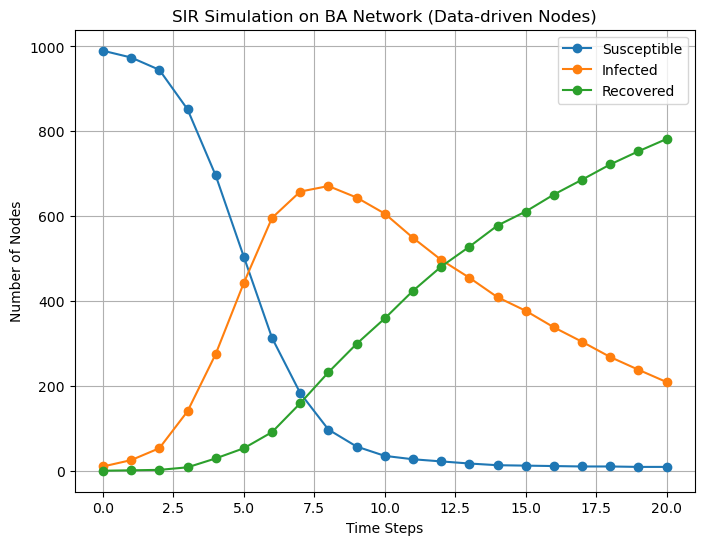

In [10]:
# Define SIR simulation function 
def simulate_SIR(G, initial_infected=10, infection_prob=0.2, recovery_prob=0.1, steps=20):
    """
    Simulate the SIR model on graph G.
    States: 0 = Susceptible, 1 = Infected, 2 = Recovered
    Returns final state and history dictionary with counts for S, I, R at each time step.
    """
    state = {node: 0 for node in G.nodes()}
    initial_nodes = random.sample(list(G.nodes()), initial_infected)
    for node in initial_nodes:
        state[node] = 1
    history = {'S': [sum(1 for s in state.values() if s == 0)],
               'I': [sum(1 for s in state.values() if s == 1)],
               'R': [sum(1 for s in state.values() if s == 2)]}
    for t in range(steps):
        new_state = state.copy()
        for node in G.nodes():
            if state[node] == 1:
                for neighbor in G.neighbors(node):
                    if state[neighbor] == 0 and random.random() < infection_prob:
                        new_state[neighbor] = 1
                if random.random() < recovery_prob:
                    new_state[node] = 2
        state = new_state.copy()
        history['S'].append(sum(1 for s in state.values() if s == 0))
        history['I'].append(sum(1 for s in state.values() if s == 1))
        history['R'].append(sum(1 for s in state.values() if s == 2))
    return state, history

# SIR simulation parameters
steps = 20
initial_infected = 10
infection_prob = 0.2
recovery_prob = 0.1

# Run SIR simulation on BA network
state_ba, history_ba = simulate_SIR(G_ba, initial_infected, infection_prob, recovery_prob, steps)

# Plot SIR simulation results for BA network
plt.figure(figsize=(8,6))
plt.plot(history_ba['S'], label='Susceptible', marker='o')
plt.plot(history_ba['I'], label='Infected', marker='o')
plt.plot(history_ba['R'], label='Recovered', marker='o')
plt.xlabel("Time Steps")
plt.ylabel("Number of Nodes")
plt.title("SIR Simulation on BA Network (Data-driven Nodes)")
plt.legend()
plt.grid(True)
plt.show()

### 4.2 ER Network: Graph Generation, Visualization, and SIR Simulation

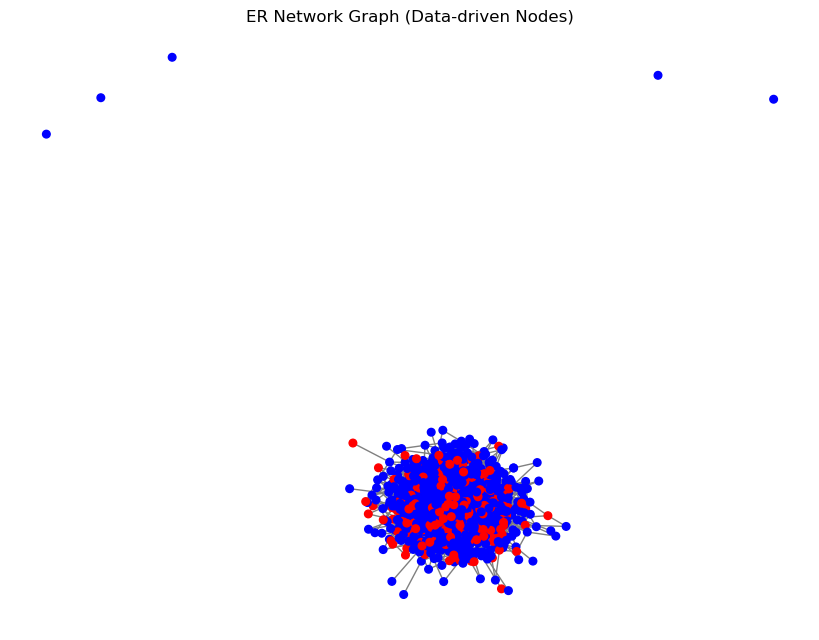

In [11]:
# Generate an ER network using the same sample
er_p = 6 / (sample_size - 1)  # set probability for average degree around 6
G_er = nx.erdos_renyi_graph(sample_size, er_p, seed=42)

# Assign node attributes from the combined sample
for i in range(sample_size):
    G_er.nodes[i]['label'] = combined_sample.loc[i, 'label']

# Visualize the ER network graph
plt.figure(figsize=(8,6))
pos_er = nx.spring_layout(G_er, seed=42)
node_colors_er = ['red' if G_er.nodes[node]['label'] == 1 else 'blue' for node in G_er.nodes()]
nx.draw(G_er, pos_er, node_color=node_colors_er, node_size=30, edge_color='gray', with_labels=False)
plt.title("ER Network Graph (Data-driven Nodes)")
plt.axis('off')
plt.show()

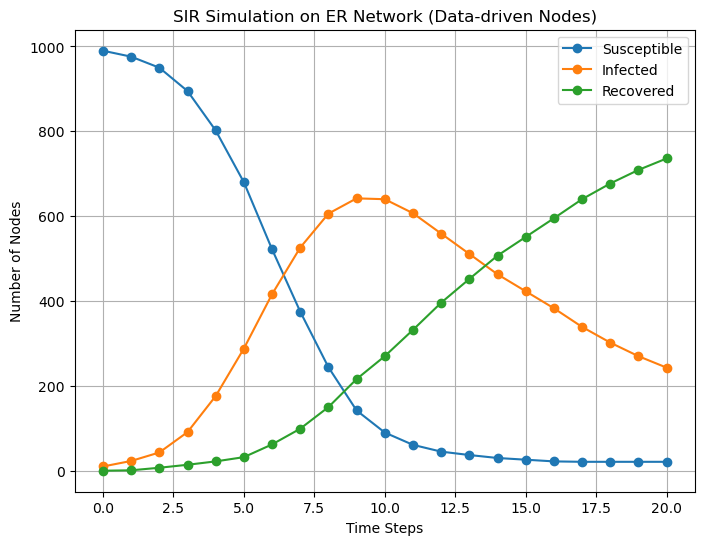

In [12]:
# Run SIR simulation on ER network
state_er, history_er = simulate_SIR(G_er, initial_infected, infection_prob, recovery_prob, steps)

# Plot SIR simulation results for ER network
plt.figure(figsize=(8,6))
plt.plot(history_er['S'], label='Susceptible', marker='o')
plt.plot(history_er['I'], label='Infected', marker='o')
plt.plot(history_er['R'], label='Recovered', marker='o')
plt.xlabel("Time Steps")
plt.ylabel("Number of Nodes")
plt.title("SIR Simulation on ER Network (Data-driven Nodes)")
plt.legend()
plt.grid(True)
plt.show()

### 4.3 SIR Simulation Summary

In [13]:
# Define simulation parameters
sample_size = 1000
ba_m = 3
er_p = 6 / (sample_size - 1)  # Calculated for ER network to achieve an average degree around 6
initial_infected = 10
infection_prob = 0.2
recovery_prob = 0.1
steps = 20

# Retrieve final simulation values from the history dictionaries
final_S_ba = history_ba['S'][-1]
final_I_ba = history_ba['I'][-1]
final_R_ba = history_ba['R'][-1]

final_S_er = history_er['S'][-1]
final_I_er = history_er['I'][-1]
final_R_er = history_er['R'][-1]

# Create a summary DataFrame
summary_data = {
    "Network Model": ["BA", "ER"],
    "Sample Size": [sample_size, sample_size],
    "Model Parameter (ba_m or er_p)": [ba_m, er_p],
    "Initial Infected": [initial_infected, initial_infected],
    "Infection Prob.": [infection_prob, infection_prob],
    "Recovery Prob.": [recovery_prob, recovery_prob],
    "Steps": [steps, steps],
    "Final Susceptible": [final_S_ba, final_S_er],
    "Final Infected": [final_I_ba, final_I_er],
    "Final Recovered": [final_R_ba, final_R_er]
}

summary_df = pd.DataFrame(summary_data)

print("SIR Simulation Summary:")
print(summary_df)

SIR Simulation Summary:
  Network Model  Sample Size  Model Parameter (ba_m or er_p)  \
0            BA         1000                        3.000000   
1            ER         1000                        0.006006   

   Initial Infected  Infection Prob.  Recovery Prob.  Steps  \
0                10              0.2             0.1     20   
1                10              0.2             0.1     20   

   Final Susceptible  Final Infected  Final Recovered  
0                  9             209              782  
1                 21             243              736  


## 5. Sensitivity Analysis

I explore how varying the infection probability affects the final epidemic size (measured as the average final recovered count) for both BA and ER networks.

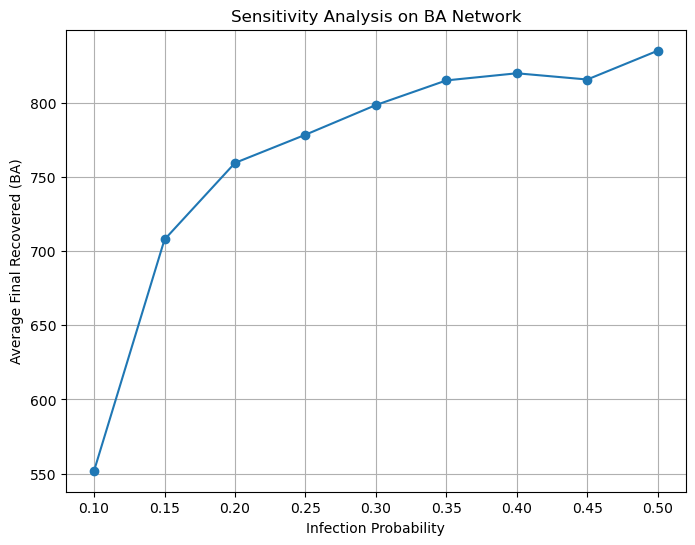

In [14]:
# Sensitivity Analysis for BA Network
infection_probs = np.linspace(0.1, 0.5, 9)
runs = 5
final_recovered_avg_ba = []

for ip in infection_probs:
    recovered_list = []
    for _ in range(runs):
        _, history = simulate_SIR(G_ba, initial_infected, ip, recovery_prob, steps)
        recovered_list.append(history['R'][-1])
    final_recovered_avg_ba.append(np.mean(recovered_list))

plt.figure(figsize=(8,6))
plt.plot(infection_probs, final_recovered_avg_ba, marker='o')
plt.xlabel("Infection Probability")
plt.ylabel("Average Final Recovered (BA)")
plt.title("Sensitivity Analysis on BA Network")
plt.grid(True)
plt.show()

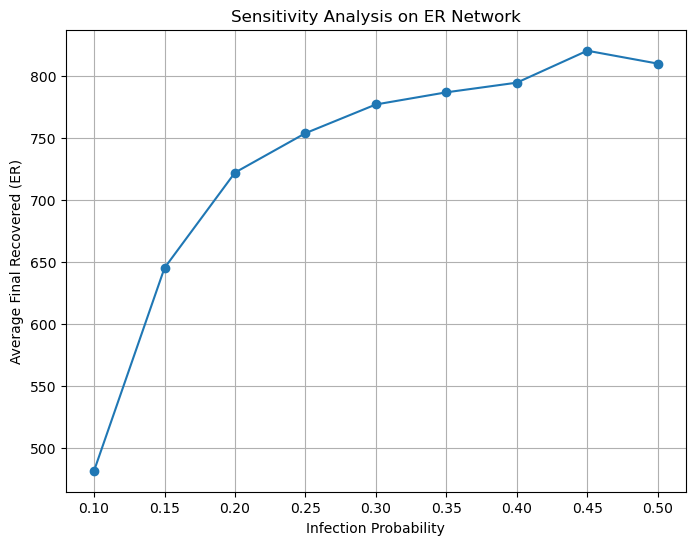

In [15]:
# Sensitivity Analysis for ER Network
final_recovered_avg_er = []

for ip in infection_probs:
    recovered_list = []
    for _ in range(runs):
        _, history = simulate_SIR(G_er, initial_infected, ip, recovery_prob, steps)
        recovered_list.append(history['R'][-1])
    final_recovered_avg_er.append(np.mean(recovered_list))

plt.figure(figsize=(8,6))
plt.plot(infection_probs, final_recovered_avg_er, marker='o')
plt.xlabel("Infection Probability")
plt.ylabel("Average Final Recovered (ER)")
plt.title("Sensitivity Analysis on ER Network")
plt.grid(True)
plt.show()

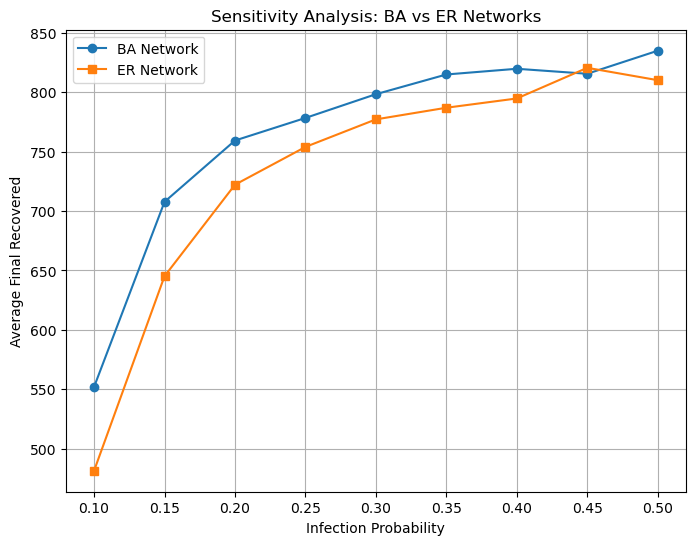

In [19]:
plt.figure(figsize=(8,6))
plt.plot(infection_probs, final_recovered_avg_ba, marker='o', label='BA Network')
plt.plot(infection_probs, final_recovered_avg_er, marker='s', label='ER Network')
plt.xlabel("Infection Probability")
plt.ylabel("Average Final Recovered")
plt.title("Sensitivity Analysis: BA vs ER Networks")
plt.legend()
plt.grid(True)
plt.show()

## 6. Advanced Network Metrics and Community Detection

I compute advanced network metrics (betweenness, closeness, eigenvector centrality) and perform community detection using the Louvain algorithm for both BA and ER networks.

BA Network - Top 5 Betweenness Centrality:
Node 4: 0.1513
Node 6: 0.1306
Node 5: 0.1263
Node 7: 0.1112
Node 12: 0.0733
Average Closeness (BA): 0.2911
Average Eigenvector Centrality (BA): 0.0192
BA Communities: 16, Modularity: 0.3904


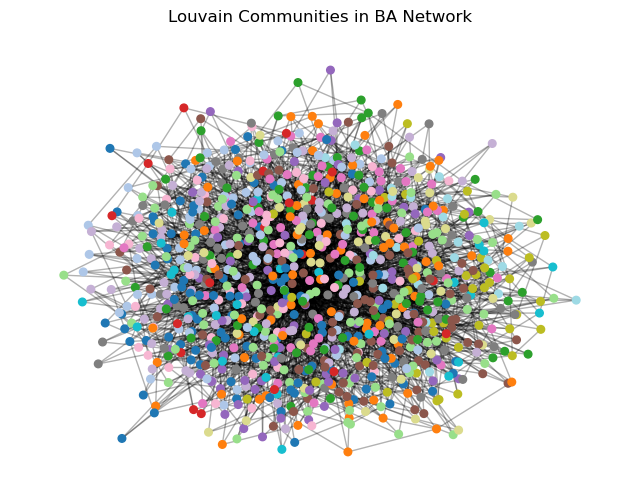

In [16]:
# Advanced Metrics for BA Network
betweenness_ba = nx.betweenness_centrality(G_ba)
closeness_ba = nx.closeness_centrality(G_ba)
eigenvector_ba = nx.eigenvector_centrality(G_ba)

print("BA Network - Top 5 Betweenness Centrality:")
for node, val in sorted(betweenness_ba.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"Node {node}: {val:.4f}")
print(f"Average Closeness (BA): {np.mean(list(closeness_ba.values())):.4f}")
print(f"Average Eigenvector Centrality (BA): {np.mean(list(eigenvector_ba.values())):.4f}")

# Louvain Community Detection on BA Network
partition_ba = community_louvain.best_partition(G_ba)
num_communities_ba = len(set(partition_ba.values()))
modularity_ba = community_louvain.modularity(partition_ba, G_ba)
print(f"BA Communities: {num_communities_ba}, Modularity: {modularity_ba:.4f}")

# Visualize BA communities
colors_ba = [partition_ba[node] for node in G_ba.nodes()]
pos_ba = nx.spring_layout(G_ba, seed=42)
plt.figure(figsize=(8,6))
nx.draw_networkx_nodes(G_ba, pos_ba, node_size=30, node_color=colors_ba, cmap=plt.cm.tab20)
nx.draw_networkx_edges(G_ba, pos_ba, alpha=0.3)
plt.title("Louvain Communities in BA Network")
plt.axis('off')
plt.show()

ER Network - Top 5 Betweenness Centrality:
Node 693: 0.0143
Node 291: 0.0140
Node 763: 0.0136
Node 572: 0.0132
Node 43: 0.0132
Average Closeness (ER): 0.2466
Average Eigenvector Centrality (ER): 0.0280
ER Communities: 22, Modularity: 0.3919


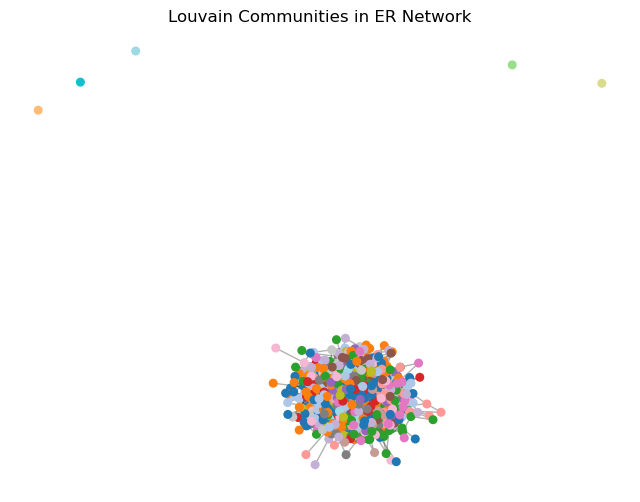

In [17]:
# Advanced Metrics for ER Network
betweenness_er = nx.betweenness_centrality(G_er)
closeness_er = nx.closeness_centrality(G_er)
eigenvector_er = nx.eigenvector_centrality(G_er)

print("ER Network - Top 5 Betweenness Centrality:")
for node, val in sorted(betweenness_er.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"Node {node}: {val:.4f}")
print(f"Average Closeness (ER): {np.mean(list(closeness_er.values())):.4f}")
print(f"Average Eigenvector Centrality (ER): {np.mean(list(eigenvector_er.values())):.4f}")

# Louvain Community Detection on ER Network
partition_er = community_louvain.best_partition(G_er)
num_communities_er = len(set(partition_er.values()))
modularity_er = community_louvain.modularity(partition_er, G_er)
print(f"ER Communities: {num_communities_er}, Modularity: {modularity_er:.4f}")

# Visualize ER communities
colors_er = [partition_er[node] for node in G_er.nodes()]
pos_er = nx.spring_layout(G_er, seed=42)
plt.figure(figsize=(8,6))
nx.draw_networkx_nodes(G_er, pos_er, node_size=30, node_color=colors_er, cmap=plt.cm.tab20)
nx.draw_networkx_edges(G_er, pos_er, alpha=0.3)
plt.title("Louvain Communities in ER Network")
plt.axis('off')
plt.show()

In [18]:
# Calculate average metrics for BA network
avg_betweenness_ba = np.mean(list(betweenness_ba.values()))
avg_closeness_ba = np.mean(list(closeness_ba.values()))
avg_eigen_ba = np.mean(list(eigenvector_ba.values()))
num_communities_ba = len(set(partition_ba.values()))
modularity_ba_val = modularity_ba

# Calculate average metrics for ER network
avg_betweenness_er = np.mean(list(betweenness_er.values()))
avg_closeness_er = np.mean(list(closeness_er.values()))
avg_eigen_er = np.mean(list(eigenvector_er.values()))
num_communities_er = len(set(partition_er.values()))
modularity_er_val = modularity_er

# Create a summary DataFrame
metrics_summary = pd.DataFrame({
    "Metric": ["Betweenness Centrality", "Closeness Centrality", "Eigenvector Centrality", 
               "Number of Communities", "Modularity"],
    "BA Network (Average)": [avg_betweenness_ba, avg_closeness_ba, avg_eigen_ba, num_communities_ba, modularity_ba_val],
    "ER Network (Average)": [avg_betweenness_er, avg_closeness_er, avg_eigen_er, num_communities_er, modularity_er_val]
})

print("Advanced Network Metrics Comparison:")
print(metrics_summary)

Advanced Network Metrics Comparison:
                   Metric  BA Network (Average)  ER Network (Average)
0  Betweenness Centrality              0.002471              0.003009
1    Closeness Centrality              0.291087              0.246600
2  Eigenvector Centrality              0.019238              0.028041
3   Number of Communities             16.000000             22.000000
4              Modularity              0.390368              0.391853


## 7. Conclusions and Future Work

In this notebook I have:
- Loaded and preprocessed four FakeNewsNet datasets.
- Combined them and assigned fake/real labels.
- Built classification models (TF-IDF baseline and fine-tuned BERT) for fake news detection.
- Generated synthetic networks (BA and ER) with data-driven node attributes.
- Visualized network graphs and simulated misinformation spread using an SIR model.
- Performed sensitivity analysis on infection probability.
- Computed advanced network metrics and performed community detection using the Louvain algorithm.

**Future Work:**  
- Extend sensitivity analysis to other parameters (recovery probability, initial infected count).  
- Incorporate classification outcomes as node weights for more nuanced simulations.  
- Compare synthetic results with real-world social network interaction data.  
- Explore targeted mitigation strategies based on network centrality and community structure.